This is a revised version of Programming Assignment 2 for CM50270: Reinforcement Learning 

Revision Date: 09/03/2021 <br>
Reason for Revision: Student Feedback

Changes from the original version:
- Total time limit increased from 8 minutes to 10 minutes. 
- Minimum number of agents averaged in Exercise 5 decreased from 20 to 2.

# CM50270 Reinforcement Learning
## Coursework Part 2: Racetrack

In this exercise, you will implement and compare the performance of three reinforcement learning algorithms: On-Policy First-Visit Monte-Carlo Control, Sarsa, and Q-Learning.

**Total number of marks:** 40 marks.

**What to submit:** Your completed Jupyter notebook (.ipynb file) which should include **all** of your source code. Please **do not change the file name or compress/zip your submission**. Please do not include any identifying information on the files you submit. This coursework will be marked **anonymously**.

**Where to submit:** CM50270 Moodle Page.

You are required to **work individually**. You are welcome to discuss ideas with others but you must design your own implementation and **write your own code**.

**Do not plagiarise**. Plagiarism is a serious academic offence. For details on what plagiarism is and how to avoid it, please visit the following webpage: http://www.bath.ac.uk/library/help/infoguides/plagiarism.html

If you are asked to use specific variable names, data-types, function signatures and notebook cells, **please ensure that you follow these instructions**. Not doing so will cause the automarker to reject your work, and will assign you a score of zero for that question. **If the automarker rejects your work because you have not followed the instructions, you may not get any credit for your work**.

Please **do not use any non-standard, third-party libraries** apart from numpy and matplotlib. In this part of the coursework, you should also use the `racetrack_env` file, which we have provided for you. **If we are unable to run your code because you have used unsupported external libraries, you may not get any credit for your work.**

Please remember to **save your work regularly**.

Please be sure to **restart the kernel and run your code from start-to-finish** (Kernel → Restart & Run All) before submitting your notebook. Otherwise, you may not be aware that you are using variables in memory that you have deleted.

Your total runtime must be less than **10 minutes** on the University's computers, and **written answer length limits** must be adhered to. Otherwise, you may not get credit for your work. You can run your code on the university's computers remotely using [UniDesk](https://bath.topdesk.net/tas/public/ssp/content/detail/knowledgeitem?unid=ff3266344c1d4eb2acb227cc9e3e1eee)

## The Racetrack Environment
We have implemented a custom environment called "Racetrack" for you to use during this piece of coursework. It is inspired by the environment described in the course textbook (Reinforcement Learning, Sutton & Barto, 2018, Exercise 5.12), but is not exactly the same.

### Environment Description
Consider driving a race car around a turn on a racetrack. In order to complete the race as quickly as possible, you would want to drive as fast as you can but, to avoid running off the track, you must slow down while turning.

In our simplified racetrack environment, the agent is at one of a discrete set of grid positions. The agent also has a discrete speed in two directions, $x$ and $y$. So the state is represented as follows:
$$(\text{position}_y, \text{position}_x, \text{velocity}_y, \text{velocity}_x)$$

The agent collects a reward of -1 at each time step, an additional -10 for leaving the track (i.e., ending up on a black grid square in the figure below), and an additional +10 for reaching the finish line (any of the red grid squares). The agent starts each episode in a randomly selected  grid-square on the starting line (green grid squares) with a speed of zero in both directions. At each time step, the agent can change its speed in both directions. Each speed can be changed by +1, -1 or 0, giving a total of nine actions. For example, the agent may increase its speed in the $x$ direction by -1 and its speed in the $y$ direction by +1. The agent's speed cannot be greater than +10 or less than -10 in either direction.

<img src="images/track_big.png" style="width: 600px;"/>


The agent's next state is determined by its current grid square, its current speed in two directions, and the changes it  makes to its speed in the two directions. This environment is stochastic. When the agent tries to change its speed, no change occurs (in either direction) with probability 0.2. In other words, 20% of the time, the agent's action is ignored and the car's speed remains the same in both directions.

If the agent leaves the track, it is returned to a random start grid-square and has its speed set to zero in both directions; the episode continues. An episode ends only when the agent transitions to a goal grid-square.



### Environment Implementation
We have implemented the above environment in the `racetrack_env.py` file, for you to use in this coursework. Please use this implementation instead of writing your own, and please do not modify the environment.

We provide a `RacetrackEnv` class for your agents to interact with. The class has the following methods:
- **`reset()`** - this method initialises the environment, chooses a random starting state, and returns it. This method should be called before the start of every episode.
- **`step(action)`** - this method takes an integer action (more on this later), and executes one time-step in the environment. It returns a tuple containing the next state, the reward collected, and whether the next state is a terminal state.
- **`render(sleep_time)`** - this method renders a matplotlib graph representing the environment. It takes an optional float parameter giving the number of seconds to display each time-step. This method is useful for testing and debugging, but should not be used during training since it is *very* slow. **Do not use this method in your final submission**.
- **`get_actions()`** - a simple method that returns the available actions in the current state. Always returns a list containing integers in the range [0-8] (more on this later).

In our code, states are represented as Python tuples - specifically a tuple of four integers. For example, if the agent is in a grid square with coordinates ($Y = 2$, $X = 3$), and is moving zero cells vertically and one cell horizontally per time-step, the state is represented as `(2, 3, 0, 1)`. Tuples of this kind will be returned by the `reset()` and `step(action)` methods.

There are nine actions available to the agent in each state, as described above. However, to simplify your code, we have represented each of the nine actions as an integer in the range [0-8]. The table below shows the index of each action, along with the corresponding changes it will cause to the agent's speed in each direction.

<img src="images/action_grid.png" style="width: 250px;"/>

For example, taking action 8 will increase the agent's speed in the $x$ direction, but decrease its speed in the $y$ direction.

### Racetrack Code Example
Below, we go through a quick example of using the `RaceTrackEnv` class.

First, we import the class, then create a `RaceTrackEnv` object called `env`. We then initialise the environment using the `reset()` method, and take a look at the initial state variable and the result of `plot()`.


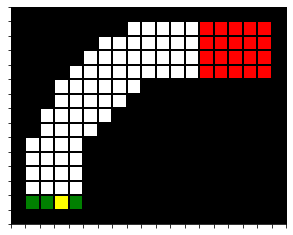

Initial State: (1, 3, 0, 0)


In [1]:
%matplotlib inline

# Set random seed to make example reproducable.
import numpy as np
import random
seed = 5
random.seed(seed)
np.random.seed(seed)

from racetrack_env import RacetrackEnv

# Instantiate environment object.
env = RacetrackEnv()

# Initialise/reset environment.
state = env.reset()
env.render()
print("Initial State: {}".format(state))

As you can see, `reset()` has returned a valid initial state as a four-tuple. The function `plot()` uses the same colour-scheme as described above, but also includes a yellow grid-square to indicate the current position of the agent.

Let's make the agent go upward by using `step(1)`, then inspect the result (recall that action `1` increments the agent's vertical speed while leaving the agent's horizontal speed unchanged).

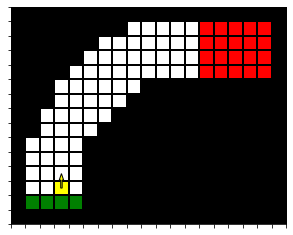

Next State: (2, 3, 1, 0), Reward: -1, Terminal: False


In [2]:
# Let us increase the agent's vertical speed (action 1).
next_state, reward, terminal = env.step(1)
env.render()
print("Next State: {}, Reward: {}, Terminal: {}".format(next_state, reward, terminal))

You can see that the agent has moved one square upwards, and now has a positive vertical speed (indicated by the yellow arrow). Let's set up a loop to see what happens if we take the action a few more times, causing it to repeatedly leave the track.

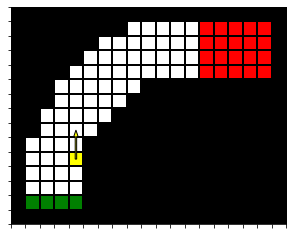

In [3]:
num_steps = 50
for t in range(num_steps) :
    next_state, reward, terminal = env.step(1)
    env.render()

## Exercise 1: On-Policy MC Control (8 Marks)

In this exercise, you will implement an agent which learns to reach a goal state in the racetrack task using On-Policy First-Visit MC Control, the pseudocode for which is reproduced below (Reinforcement Learning, Sutton & Barto, 2018, Section 5.4 p.101).

<img src="images/mc_control_algo.png" style="width: 650px;"/>

Please produce the following:
- A tabular **On-Policy First-Visit MC Control agent** which learns an optimal policy in the racetrack environment.
- An **average learning curve**. Your learning curve should plot the mean **undiscounted return** from many agents as a function of episodes. Please specify how many agents' performances you are averaging in the title of your plot. This should be a dynamic figure that we can produce by running your code. If you wish to use any kind of graph smoothing, please also include an un-smoothed version of your graph, and ensure that your smoothing method does not cause artifacts near the edges of the plot.

Please use the following parameter settings:
- Discount factor $\gamma = 0.9$.
- For your $\epsilon$-greedy policy, use exploratory action probability $\epsilon = 0.15$.
- Number of training episodes $= 150$.
- Number of agents averaged should be at **least** 20.

**If you use incorrect parameters, you may not get any credit for your work.**

In [4]:
import matplotlib.pyplot as plt

In [5]:
def e_soft(state, p_values, actions, epsilon):
    
    if state not in p_values:
        p_values[state] = {0:1/9,1:1/9,2:1/9,3:1/9,4:1/9,5:1/9,6:1/9,7:1/9,8:1/9}
        
    action_probs = []
    for action in actions:
        action_probs.append(p_values[state][action])

    action = np.random.choice(actions, p=action_probs)
        
    return action, p_values

In [6]:
def MC_control(env, num_agents=25, episodes=150, gamma=0.9, epsilon=0.15):
    
    rewards_per_episode = np.zeros(episodes)
    actions = environment.get_actions()
    
    for agent in range(num_agents):
        
        # Dictionary that stores states, for each state we have a dictionary for actions
        # {(1, 3, 0, 0):{1:.., 2:... ...}, ...}
        q_values = {}
        # {(1, 3, 0, 0):{1:1/9, 2:1/9, ...}, ...}
        p_values = {}
        # {(1, 3, 0, 0):{1:[.,.,..], 2:[.,.,..], ...}, ...}
        returns = {}

        # Generate an episode
        for episode in range(episodes):
            
            state = environment.reset()
            game_over = False

            # Recording the steps of the episode
            episode_steps = []
            first_visit = []
            cumulative_reward = 0

            # Loop for each step of episode
            while not game_over:
                                
                # Choose action from S using derive policy (e_greedy)
                action, new_p_values = e_soft(state, p_values, actions, epsilon)
                p_values = new_p_values
                
                # Take action A and observe reward and next state
                next_state, reward, game_over = environment.step(action)
                
                episode_steps.append((state, action, reward))
                
                if (state, action) not in first_visit:
                    first_visit.append((state, action))
                
                state = next_state
                game_over = game_over
                cumulative_reward += reward

            rewards_per_episode[episode] += cumulative_reward
            G = 0
            
            # Loop for each step of episode
            for step in episode_steps:

                state, action, reward = step
                
                G = gamma*G + reward

                # We care about the first visit of the state action pair, per episode
                if (state, action) in first_visit:
                    

                    first_visit.remove((state, action))
                    
                    # Append G to returns
                    if state in returns:
                        returns[state][action].append(G)
                    else:
                        returns[state] = {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[]}
                        returns[state][action].append(G)
            
                    if state not in q_values:
                        q_values[state] = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0}

                    q_values[state][action] = np.mean(returns[state][action])
                    
                    # Store in A* the best action from the current state
                    A_star = max(q_values[state], key=q_values[state].get)
                    
                    # Update the p_values for the state action pair
                    for action in actions:
                        if action == A_star:
                            p_values[state][action] = 1 - epsilon + (epsilon/9)
                        else: 
                            p_values[state][action] = epsilon/9

            
    rewards_per_episode = rewards_per_episode / num_agents
                
    return rewards_per_episode

environment = RacetrackEnv()
%time mcControl_rewards = MC_control(environment)

Wall time: 1min 24s


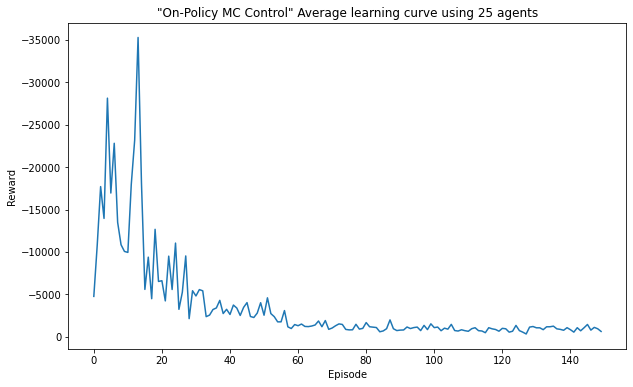

In [7]:
# Please write your code for Exercise 1 in this cell or in as many cells as you want ABOVE this cell.
# You should implement your MC agent and plot your average learning curve here.
# Do NOT delete this cell.

x_episodes = [i for i in range(len(mcControl_rewards))]
plt.figure(figsize=(10,6))

plt.plot(x_episodes, mcControl_rewards, '-', color='tab:blue')
plt.gca().invert_yaxis()

plt.title('"On-Policy MC Control" Average learning curve using 25 agents')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

## Exercise 2: Sarsa (4 Marks)

In this exercise, you will implement an agent which learns to reach a goal state in the racetrack task using the Sarsa algorithm, the pseudocode for which is reproduced below (Reinforcement Learning, Sutton & Barto, 2018, Section 6.4 p.129).

<img src="images/sarsa_algo.png" style="width: 650px;"/>

Please produce the following:

- A tabular **Sarsa agent** which learns an optimal policy in the racetrack environment.
- An **average learning curve**. Your learning curve should plot the mean **undiscounted return** from many agents as a function of episodes. Please specify how many agents' performances you are averaging in the title of your plot. This should be a dynamic figure that we can produce by running your code. If you wish to use any kind of graph smoothing, please also include an un-smoothed version of your graph, and ensure that your smoothing method does not cause artifacts near the edges of the plot.

Please use the following parameter settings:
- Step size parameter $\alpha = 0.2$.
- Discount factor $\gamma = 0.9$.
- For your $\epsilon$-greedy policy, use exploratory action probability $\epsilon = 0.15$.
- Number of training episodes $= 150$.
- Number of agents averaged should be at **least** 20.

**If you use incorrect parameters, you may not get any credit for your work.**

In [8]:
def e_greedy(state, q_values, actions, epsilon):
    # Action using epsilon greedy policy
    if np.random.uniform(0, 1) < epsilon or state not in q_values:
        action = np.random.randint(0, len(actions))
    else:
        # Finding the optimal action with the highest value Using the q_values dictionary
        action = max(q_values[state], key=q_values[state].get)
        
    return action

In [9]:
def sarsa(environment, num_agents=25, episodes=150, alpha=0.2, gamma=0.9, epsilon=0.15):

    rewards_per_episode = np.zeros(episodes)
    actions = environment.get_actions()

    for agent in range(num_agents):
        
        # Dictionary that stores states, for each state we have a dictionary for actions
        # {(1, 3, 0, 0):{1:.., 2:... ...}, ...}
        q_values = {}
        
        for episode in range(episodes):
            
            # Initialize S
            state = environment.reset()
            game_over = False
            cumulative_reward = 0
            
            # Choose A from S using e-greedy
            action = e_greedy(state, q_values, actions, epsilon)
            
            # Loop for each step of episode
            while not game_over:
                
                # Take action A observe next state and reward
                next_state, reward, game_over = environment.step(action) 
                
                # Choosing next action from next state using e-greedy
                next_action = e_greedy(next_state, q_values, actions, epsilon)
                
                # Initializing state if never previously seen
                if state not in q_values:
                    q_values[state] = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0}
                
                # Finding q_value of current state and action
                q_current = q_values[state][action]
                
                # Initializing next state if never previously seen
                if next_state not in q_values:
                    q_values[next_state] = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0}
                    q_next = 0
                else:
                    # If seen again we get the next q_value stored for next state on next action
                    q_next = q_values[next_state][next_action]
                
                # Substituting the new q_value for state action pair
                q_values[state][action] = q_current + alpha*(reward + gamma*q_next - q_current)
                
                # Storing next state and next action to be taken
                state = next_state
                action = next_action
                cumulative_reward += reward
                
                game_over = game_over
            
            rewards_per_episode[episode] += cumulative_reward
            
    rewards_per_episode = rewards_per_episode / num_agents
        
    return rewards_per_episode

environment = RacetrackEnv()
%time sarsa_rewards = sarsa(environment)

Wall time: 3.43 s


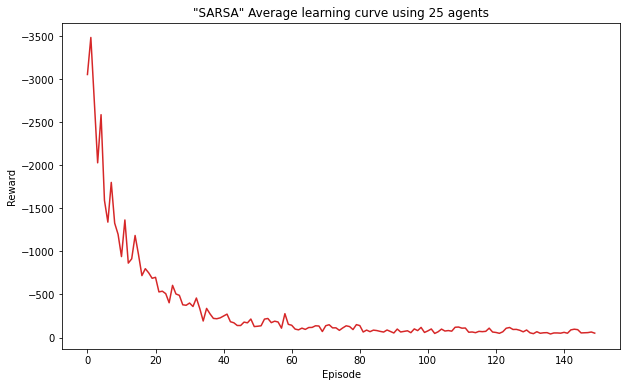

In [10]:
# Please write your code for Exercise 2 in this cell or in as many cells as you want ABOVE this cell.
# You should implement your sarsa agent and plot your average learning curve here.
# Do NOT delete this cell.

x_episodes = [i for i in range(len(sarsa_rewards))]
plt.figure(figsize=(10,6))

plt.plot(x_episodes, sarsa_rewards, '-', color='tab:red')
plt.gca().invert_yaxis()

plt.title('"SARSA" Average learning curve using 25 agents')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

## Exercise 3: Q-Learning (4 Marks)

In this exercise, you will implement an agent which learns to reach a goal state in the racetrack task using the Q-Learning algorithm, the pseudocode for which is reproduced below (Reinforcement Learning, Sutton & Barto, 2018, Section 6.5 p.131).

<img src="images/q_learning_algo.png" style="width: 650px;"/>

Please produce the following:

- A tabular **Q-Learning agent** which learns an optimal policy in the racetrack environment.
- An **average learning curve**. Your learning curve should plot the mean **undiscounted return** from many agents as a function of episodes. Please specify how many agents' performances you are averaging in the title of your plot. This should be a dynamic figure that we can produce by running your code. If you wish to use any kind of graph smoothing, please also include an un-smoothed version of your graph, and ensure that your smoothing method does not cause artifacts near the edges of the plot.

Please use the following parameter settings:
- Step size parameter $\alpha = 0.2$.
- Discount factor $\gamma = 0.9$.
- For your $\epsilon$-greedy policy, use exploratory action probability $\epsilon = 0.15$.
- Number of training episodes $= 150$.
- Number of agents averaged should be at **least** 20.

**If you use incorrect parameters, you may not get any credit for your work.**

Hint: Your Q-Learning implementation is likely to be similar to your Sarsa implementation. Think hard about where these two algorithms differ.

In [11]:
def q_learning(environment, num_agents=25, episodes=150, alpha=0.2, gamma=0.9, epsilon=0.15):

    rewards_per_episode = np.zeros(episodes)
    actions = environment.get_actions()

    for agent in range(num_agents):
        
        # Dictionary that stores states, for each state we have a dictionary for actions 
        # with values as their corresponding q_values
        # {(1, 3, 0, 0):{1:.., 2:... 3:..., ...}, (1, 4, 0, 0):{1:.., 2:... 3:..., ...}, ...}
        q_values = {}
        
        # Loop for each episode
        for episode in range(episodes):
            
            state = environment.reset()
            game_over = False
            cumulative_reward = 0
            
            # Loop for each step of episode
            while not game_over:
                
                # Choose action from S using derive policy (e_greedy)
                action = e_greedy(state, q_values, actions, epsilon)
                
                # Take action A and observe reward and next state
                next_state, reward, game_over = environment.step(action)
                
                # Initializing state if never previously seen
                if state not in q_values or action not in q_values[state]:
                    q_values[state] = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0}
                
                # Finding q_value of current state and action
                q_current = q_values[state][action]
                
                # Finding max q_value of optimal action of the next state
                if next_state not in q_values or action not in q_values[next_state]:
                    q_next = 0
                else:
                    q_next = max(q_values[next_state], key=q_values[next_state].get)
                
                # Substituting the new q_value for state action pair
                q_values[state][action] = q_current + alpha*(reward + gamma*q_next - q_current)
                
                # Storing next state
                state = next_state
                
                cumulative_reward += reward
                game_over = game_over
            
            rewards_per_episode[episode] += cumulative_reward
            
    rewards_per_episode = rewards_per_episode / num_agents
        
    return rewards_per_episode

environment = RacetrackEnv()
%time qlearning_rewards = q_learning(environment)

Wall time: 14.1 s


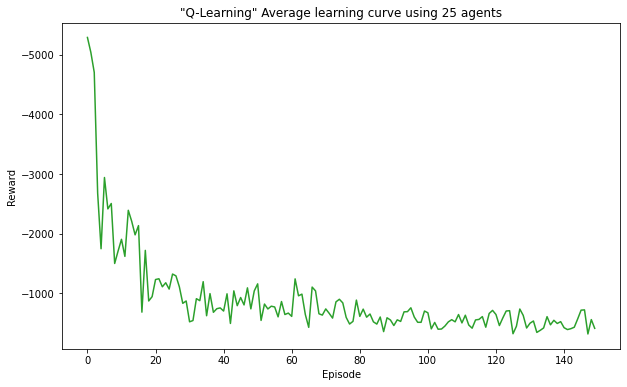

In [12]:
# Please write your code for Exercise 3 in this cell or in as many cells as you want ABOVE this cell.
# You should implement your q-learning agent agent and plot your average learning curve here.
# Do NOT delete this cell.

x_episodes = [i for i in range(len(qlearning_rewards))]
plt.figure(figsize=(10,6))

plt.plot(x_episodes, qlearning_rewards, '-', color='tab:green')
plt.gca().invert_yaxis()

plt.title('"Q-Learning" Average learning curve using 25 agents')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

## Exercise 4: Comparison & Discussion (8 Marks)

Please produce a plot which shows the data from your previous three graphs plotted together on the same set of axes. Be sure to include plot elements such as [axis labels, titles](https://matplotlib.org/3.3.3/tutorials/text/text_intro.html), and a [legend](https://matplotlib.org/3.3.3/tutorials/intermediate/legend_guide.html), so that it is clear which data series corresponds to the performance of which agent. **If we are not able to easily interpret your plots, you may not get any credit for your work.**

Please note that **you should not re-train your agents from scratch**. You should re-use your results from the previous exercises.

To improve the visual clarity of your graphs, you may wish to apply some kind of cropping or smoothing. If you choose to do this, please also include an un-altered version of your graph. Please ensure that any graph smoothing method you use does not cause artifacts near the edges of the plot.

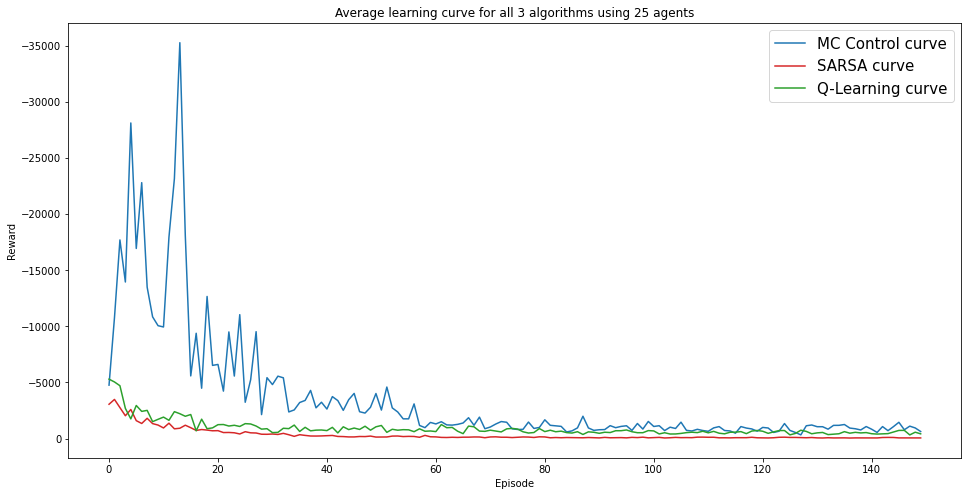

In [13]:
# Please write your code for Exercise 4 in this cell or in as many cells as you want ABOVE this cell.
# You should plot your combined graph here, clearly showing each of the average learning curves of your three agents.
# Do NOT delete this cell.

x_episodes = [i for i in range(len(qlearning_rewards))]
plt.figure(figsize=(16,8))

plt.plot(x_episodes, mcControl_rewards, '-', color='tab:blue', label='MC Control curve')
plt.plot(x_episodes, sarsa_rewards, '-', color='tab:red', label='SARSA curve')
plt.plot(x_episodes, qlearning_rewards, '-', color='tab:green', label='Q-Learning curve')

plt.gca().invert_yaxis()

plt.title('Average learning curve for all 3 algorithms using 25 agents')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend(loc='upper right', prop={'size': 15})

plt.show()

In **eight sentences** or fewer, please discuss the following:
- The performance of your different agents.
- Why each of your agents performed differently.
- Explain the differences you saw, and expected to see, between the performances and polices of your Sarsa and Q-Learning agents.
- What could be done to improve the performance of your agents?

Evaluating the performance of my different implemented agents I observed that SARSA was performing better than the other agents as it both converged faster and had the smallest negative reward throughout all of the episodes. 
On the other hand, MC control performed the worst, taking over 50 episodes for it to converge to an okay performing state.

I had expected MC control to have a much better performance but with the results that I got, its issue maybe that it updates its policy only after an episode had ended whereas the other agents update their policies with each step, causing very slow convergence with high variance as observed with the number of spikes in its corresponding blue curve. Additionally, MC uses the e-soft policy whereas Sarsa and Q-learning use e-greedy policy.

The difference of implementation between the 2 agents is nothing more that some change in the updating method for the Q-values, as Q-learning gets the current best action to take to maximize the expected reward, Sarsa uses the q_value on the next state and action to be taken. The difference in performance that I observed was that Sarsa performed much better than Q-learning throughout the whole number of training episodes but over time they should both converge to the same optimal state. As SARSA prevents hitting the wall during the exporation phase it may not learn the optimal policy at the fastest time but all in all it has a better on-line performance than Q-learning.

Possible improvements that can applied to the agents could be using temporal difference learning methods with higher number of look ahead steps, trying to mimic monte carlo whilst still updating the agent's policy with each step iteration (eg. Sarsa(λ))

## Exercise 5: Modified Q-Learning Agent (16 Marks)
### Exercise 5a: Implementation
In this exercise, you will implement an agent which learns to reach a goal state in the racetrack task using the Q-Learning algorithm, the pseudocode for which is reproduced below (Reinforcement Learning, Sutton & Barto, 2018, Section 6.5 p.131).

<img src="images/q_learning_algo.png" style="width: 650px;"/>

In order to score high marks in this exercise, you will need to extend your solution beyond a simple Q-Learning agent to achieve more efficient learning (i.e., using fewer interactions with the environment). Ideas for improving your agent will have been discussed in lectures, and can be found in the course textbook (Reinforcement Learning, Sutton & Barto, 2018). However you go about improving your agent, it must still use **tabular Q-Learning** at its core.

Please produce the following:
- A tabular **Q-Learning agent**, with whatever modifications you believe are reasonable in order to acheieve better performance in the Racetrack domain.
- An **average learning curve**. Your learning curve should plot the mean **undiscounted return** from many agents as a function of episodes. Please specify how many agents' performances you are averaging in the title of your plot. This should be a dynamic figure that we can produce by running your code. If you wish to use any kind of graph smoothing, please also include an un-smoothed version of your graph, and ensure that your smoothing method does not cause artifacts near the edges of the plot.

Please use the following parameter settings:
- Number of training episodes $= 150$.
- Number of agents averaged should be at **least** 2.

**If you use incorrect parameters, you may not get any credit for your work.**

You may adjust all other parameters as you see fit.

In [14]:
def dyna_q(environment, num_agents=2, episodes=150, alpha=0.2, gamma=0.9, epsilon=0.15, n=40):

    rewards_per_episode = np.zeros(episodes)
    actions = environment.get_actions()

    for agent in range(num_agents):
        
        # Dictionary that stores states, for each state we have a dictionary for actions 
        # with values as their corresponding q_values
        # {(1, 3, 0, 0):{1:.., 2:... 3:..., ...}, (1, 4, 0, 0):{1:.., 2:... 3:..., ...}, ...}
        q_values = {}
        
        # {(1, 3, 0, 0):{1:(r, s*), 2:(r, s*) 3:(r, s*), ...}, (1, 4, 0, 0):{1:.., 2:... 3:..., ...}, ...}
        model = {}
        
        # Loop for each episode
        for episode in range(episodes):
            
            state = environment.reset()
            game_over = False
            cumulative_reward = 0
            
            # Loop for each step of episode
            while not game_over:
                
                # Choose action from S using derive policy (e_greedy)
                action = e_greedy(state, q_values, actions, epsilon)
                
                # Take action A and observe reward and next state
                next_state, reward, game_over = environment.step(action)
                
                # Initializing state if never previously seen
                if state not in q_values or action not in q_values[state]:
                    q_values[state] = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0}
                    model[state] = {}
                
                # Finding q_value of current state and action
                q_current = q_values[state][action]
                
                # Finding max q_value of optimal action of the next state
                if next_state not in q_values or action not in q_values[next_state]:
                    q_next = 0
                else:
                    q_next = max(q_values[next_state], key=q_values[next_state].get)
                
                # Substituting the new q_value for state action pair
                q_values[state][action] = q_current + alpha*(reward + gamma*q_next - q_current)
                
                model[state][action] = [reward, next_state]
                
                # Looping n times
                for _ in range(n):
                    
                    random_state = random.choice(list(model.keys()))
                    random_action = random.choice(list(model[random_state].keys()))

                    reward_model, next_state_model = model[random_state][random_action]
                    
                    if next_state_model in q_values:
                        next_max = max(q_values[next_state_model], key=q_values[next_state_model].get)
                    else:
                        next_max = 0
                    
                    q_values[random_state][random_action] = q_values[random_state][random_action] + alpha * (reward_model + gamma* next_max)
                
                # Storing next state
                state = next_state
                
                cumulative_reward += reward
                game_over = game_over
            
            rewards_per_episode[episode] += cumulative_reward
            
    rewards_per_episode = rewards_per_episode / num_agents
        
    return rewards_per_episode

environment = RacetrackEnv()
%time dynaq_rewards = dyna_q(environment)

Wall time: 10.9 s


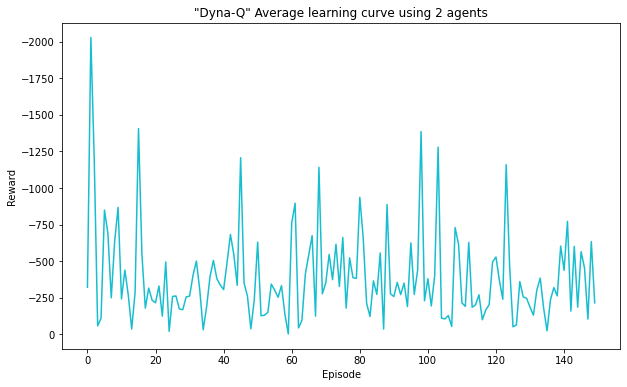

In [15]:
# Please write your code for Exercise 5a in this cell or in as many cells as you want ABOVE this cell.
# You should implement your modified q-learning agent agent and plot your average learning curve here.
# Do NOT delete this cell.

x_episodes = [i for i in range(len(dynaq_rewards))]
plt.figure(figsize=(10,6))

plt.plot(x_episodes, dynaq_rewards, '-', color='tab:cyan')
plt.gca().invert_yaxis()

plt.title('"Dyna-Q" Average learning curve using 2 agents')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

### Exercise 5b: Comparison & Discussion

Please produce a plot which shows the performance of your original Q-Learning agent and your modified Q-Learning agent. Be sure to include plot elements such as [axis labels, titles](https://matplotlib.org/3.3.3/tutorials/text/text_intro.html), and a [legend](https://matplotlib.org/3.3.3/tutorials/intermediate/legend_guide.html), so that it is clear which data series corresponds to the performance of which agent. **If we are not able to easily interpret your plots, you may not get any credit for your work.**

Please note that **you should not re-train your agents from scratch**. You should re-use your results from the previous exercises.

To improve the visual clarity of your graphs, you may wish to apply some kind of cropping or smoothing. If you choose to do this, please also include an un-altered version of your graph. Please ensure that any graph smoothing method you use does not cause artifacts near the edges of the plot.

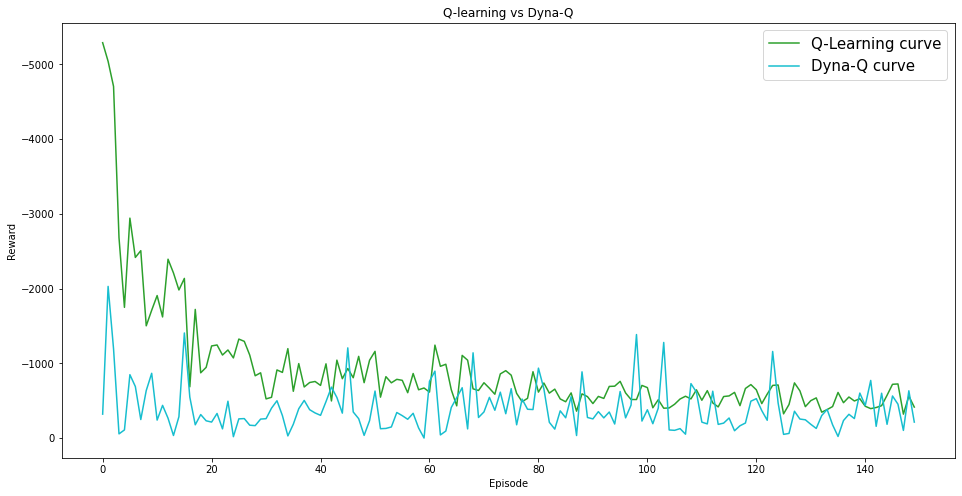

In [16]:
# Please write your code for Exercise 5b in this cell or in as many cells as you want ABOVE this cell.
# You should plot your combined graph here, clearly showing the average learning curves of your
# original and modified Q-Learning agents.
# Do NOT delete this cell.

x_episodes = [i for i in range(len(qlearning_rewards))]
plt.figure(figsize=(16,8))

plt.plot(x_episodes, qlearning_rewards, '-', color='tab:green', label='Q-Learning curve')
plt.plot(x_episodes, dynaq_rewards, '-', color='tab:cyan', label='Dyna-Q curve')

plt.gca().invert_yaxis()

plt.title('Q-learning vs Dyna-Q')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend(loc='upper right', prop={'size': 15})

plt.show()

In **eight sentences** or fewer, please discuss the following:
- The modifications that you have made to your agent beyond implementing basic Q-Learning.
- The effects you expected your additions to have, and the extent to which your expectations were met.
- Further modifications you believe may enhance the performance of your agent, or changes you would make if you had more time.

Please note that **your implementation and discussion will be assessed jointly**. This means that, in order to score highly, you will need to correctly implement appropriate modifications to your agent **AND** discuss them well.

I have added some modifications to the basic implementation of Q-learning to change it to our taught Dyna-Q algorithm. Adding the extra model learning information that can use a stochastic selection of actions, looping over 40 times, to further improve on the agent's real experience and simulated experience to make better planning decisions.
 
With this additional model control, I expected it to make a big difference on the convergence rate and performance as it had been continously proven that Dyna-Q is better performing than Q-learning. My expectations have been somewhat met as Dyna-Q has performed better, as also shown on the graph above, but it has higher variability than Q-learning with large spikes, which is possibly due to just using 2 averaged agents.

Further modifications that I could have made to better the performance of my agent could have been implementing the Dyna-Q+ algorithm. With Its addictional "exploration" bonus it could maybe help the agent plant better on how to visit long unvisited states resulting the agent being more likely to explore and find the optimal path.